In [1]:
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from copy import deepcopy
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm

from Models import tcn
from train.Dataset import CustomDataset
from train.TrainHelpers import train_model, plot_loss_graph, encode_data, train_svm
from train.TestHelpers import test_model, calculate_accuracy

if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device("mps") 
else:
    device = torch.device("cpu")
print(device)

cuda


In [2]:
### PARAMETERS ###
dataset_ver = '3w05s_Larm'
n_input = 9
n_hidden = 360
seed = 369

torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

x_train = np.load(f'Generated_Datasets/train_data_{dataset_ver}.npy')
x_val = np.load(f'Generated_Datasets/val_data_{dataset_ver}.npy')
x_test = np.load(f'Generated_Datasets/test_data_{dataset_ver}.npy')

y_train = np.load(f'Generated_Datasets/train_labels_{dataset_ver}.npy')
y_val = np.load(f'Generated_Datasets/val_labels_{dataset_ver}.npy')
y_test = np.load(f'Generated_Datasets/test_labels_{dataset_ver}.npy')

In [3]:
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)

(11578, 60, 9)
(11578,)
(1654, 60, 9)


(11578, 60, 9) (3308, 60, 9) (1654, 60, 9)


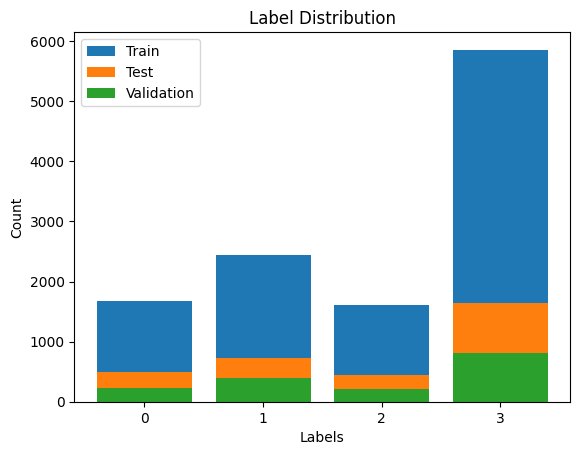

In [4]:
# Check Dataset
print(x_train.shape, x_test.shape, x_val.shape)
unique_labels_train, label_counts_train = np.unique(y_train, return_counts=True)
unique_labels_val, label_counts_val = np.unique(y_val, return_counts=True)
unique_labels_test, label_counts_test = np.unique(y_test, return_counts=True)

plt.bar(unique_labels_train, label_counts_train, label='Train')
plt.bar(unique_labels_test, label_counts_test, label='Test')
plt.bar(unique_labels_val, label_counts_val, label='Validation')

# Set the x-axis tick labels
plt.xticks(unique_labels_train, unique_labels_train)

plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Label Distribution')
plt.legend()
plt.show()

In [5]:
### Declare Dataloaders
train_dataset = CustomDataset("train", dataset_ver)
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_dataset = CustomDataset("val", dataset_ver)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=True)
test_dataset = CustomDataset("test", dataset_ver)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True)

In [6]:
for X, y in train_dataloader:
    print(f'{X.shape=}')
    print(f'{y.shape=}')
    break   

X.shape=torch.Size([1, 60, 9])
y.shape=torch.Size([1])


In [7]:
class tcn_classifier(nn.Module):
    def __init__(self, num_inputs, tcn_channels, causal, skip):
        super(tcn_classifier, self).__init__()

        # if tcn_channels[-1] != mlp_layer_dims[0]:
        #     raise ValueError("Output of TCN must match input to MLP!")

        self.tcn = tcn.TCN(num_inputs=num_inputs,
                            num_channels=tcn_channels,
                            causal=causal,
                            input_shape='NLC',
                            use_skip_connections=skip)
        
        # self.mlp = nn.Sequential()

        # for i in range(len(mlp_layer_dims)-1):
        #     self.mlp.add_module(f'fc{i+1}', nn.Linear(mlp_layer_dims[i], mlp_layer_dims[i+1]))


    def forward(self, x):
        x = self.tcn(x)
        # x = self.mlp(x)
        # print(x.shape)
        return x[0][-1]

In [14]:
def train_TCN(model, learning_rate, num_epochs, tag):
    optimizer = optim.Adam(model.parameters(),
                            lr=learning_rate,
                            betas=(0.9, 0.999),
                            eps=1e-8)

    criterion = nn.CrossEntropyLoss()

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        print(f'Starting Epoch {epoch+1}...')
        model.train()

        train_preds = []
        train_labels = []

        for train_X, train_y in tqdm(train_dataloader):
            optimizer.zero_grad()
            
            train_output = model(train_X)
            
            train_loss = criterion(train_output, train_y[0].type(torch.LongTensor))
            train_loss.backward()
            optimizer.step()

            train_preds.append(torch.argmax(train_output))
            train_labels.append(train_y)
        
        train_losses.append(train_loss.item())
        print(f'Train Loss = {train_losses[-1]}')

        train_acc = accuracy_score(train_labels, train_preds)
        print(f'Train Acc = {train_acc}')

        model.eval()

        val_preds = []
        val_labels = []

        for val_X, val_y in tqdm(val_dataloader):
            val_output = model(val_X)

            val_preds.append(torch.argmax(val_output))
            val_labels.append(val_y)

        val_losses.append(criterion(val_output, val_y[0].type(torch.LongTensor)))
        print(f'Val Loss = {val_losses[-1]}')

        val_acc = accuracy_score(val_labels, val_preds)
        print(f'Val Acc = {val_acc}')

    torch.save(deepcopy(model.state_dict()), f'ML_Models/TCN_{tag}.pt')

    return train_losses, val_losses


In [9]:
tcn_model_1 = tcn_classifier(9, [128, 64, 32, 16, 4], True, False)
print(tcn_model_1)
train_losses, val_losses = train_TCN(tcn_model_1, 1e-3, 15, 'Causal_128-64-32-16-4')

tcn_classifier(
  (tcn): TCN(
    (network): ModuleList(
      (0): TemporalBlock(
        (conv1): ParametrizedCausalConv1d(
          9, 128, kernel_size=(4,), stride=(1,)
          (parametrizations): ModuleDict(
            (weight): ParametrizationList(
              (0): _WeightNorm()
            )
          )
        )
        (conv2): ParametrizedCausalConv1d(
          128, 128, kernel_size=(4,), stride=(1,)
          (parametrizations): ModuleDict(
            (weight): ParametrizationList(
              (0): _WeightNorm()
            )
          )
        )
        (activation1): ReLU()
        (activation2): ReLU()
        (activation_final): ReLU()
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
        (downsample): Conv1d(9, 128, kernel_size=(1,), stride=(1,))
      )
      (1): TemporalBlock(
        (conv1): ParametrizedCausalConv1d(
          128, 64, kernel_size=(4,), stride=(1,), dilation=(2,)
          (parametriz

  0%|          | 0/11578 [00:00<?, ?it/s]

Train Loss = 0.32123085856437683
Train Acc = 0.7667127310416306


  0%|          | 0/1654 [00:00<?, ?it/s]

Val Loss = 0.06373973935842514
Val Acc = 0.8355501813784765
Starting Epoch 2...


  0%|          | 0/11578 [00:00<?, ?it/s]

Train Loss = 0.03527095541357994
Train Acc = 0.8577474520642598


  0%|          | 0/1654 [00:00<?, ?it/s]

Val Loss = 1.0728830375228426e-06
Val Acc = 0.8688029020556227
Starting Epoch 3...


  0%|          | 0/11578 [00:00<?, ?it/s]

Train Loss = 2.288792165927589e-05
Train Acc = 0.8903092071169459


  0%|          | 0/1654 [00:00<?, ?it/s]

Val Loss = 0.0025221463292837143
Val Acc = 0.9099153567110037
Starting Epoch 4...


  0%|          | 0/11578 [00:00<?, ?it/s]

Train Loss = 0.32999715209007263
Train Acc = 0.9103472102262913


  0%|          | 0/1654 [00:00<?, ?it/s]

Val Loss = 0.000727508042473346
Val Acc = 0.9214026602176542
Starting Epoch 5...


  0%|          | 0/11578 [00:00<?, ?it/s]

Train Loss = 0.4732154309749603
Train Acc = 0.9172568664708931


  0%|          | 0/1654 [00:00<?, ?it/s]

Val Loss = 0.003561584046110511
Val Acc = 0.9401451027811366
Starting Epoch 6...


  0%|          | 0/11578 [00:00<?, ?it/s]

Train Loss = 0.0
Train Acc = 0.9271894973225082


  0%|          | 0/1654 [00:00<?, ?it/s]

Val Loss = 1.0013530300057027e-05
Val Acc = 0.9274486094316807
Starting Epoch 7...


  0%|          | 0/11578 [00:00<?, ?it/s]

Train Loss = 0.030170027166604996
Train Acc = 0.9336673000518224


  0%|          | 0/1654 [00:00<?, ?it/s]

Val Loss = 0.016757437959313393
Val Acc = 0.9534461910519951
Starting Epoch 8...


  0%|          | 0/11578 [00:00<?, ?it/s]

Train Loss = 0.20182278752326965
Train Acc = 0.9403178441872517


  0%|          | 0/1654 [00:00<?, ?it/s]

Val Loss = 0.045221444219350815
Val Acc = 0.9195888754534461
Starting Epoch 9...


  0%|          | 0/11578 [00:00<?, ?it/s]

Train Loss = 0.009513872675597668
Train Acc = 0.9458455691829332


  0%|          | 0/1654 [00:00<?, ?it/s]

Val Loss = 0.2367507517337799
Val Acc = 0.9498186215235792
Starting Epoch 10...


  0%|          | 0/11578 [00:00<?, ?it/s]

Train Loss = 0.03166251257061958
Train Acc = 0.9492140266021766


  0%|          | 0/1654 [00:00<?, ?it/s]

Val Loss = 0.004140614531934261
Val Acc = 0.9510278113663845
Starting Epoch 11...


  0%|          | 0/11578 [00:00<?, ?it/s]

Train Loss = 0.0009334497735835612
Train Acc = 0.9528415961305925


  0%|          | 0/1654 [00:00<?, ?it/s]

Val Loss = 0.06965640932321548
Val Acc = 0.9504232164449818
Starting Epoch 12...


  0%|          | 0/11578 [00:00<?, ?it/s]

Train Loss = 0.006152025423943996
Train Acc = 0.9584556918293314


  0%|          | 0/1654 [00:00<?, ?it/s]

Val Loss = 0.00712911132723093
Val Acc = 0.9588875453446191
Starting Epoch 13...


  0%|          | 0/11578 [00:00<?, ?it/s]

Train Loss = 0.00011145447206217796
Train Acc = 0.9561236828467784


  0%|          | 0/1654 [00:00<?, ?it/s]

Val Loss = 0.0
Val Acc = 0.9540507859733979
Starting Epoch 14...


  0%|          | 0/11578 [00:00<?, ?it/s]

Train Loss = 0.0011329191038385034
Train Acc = 0.9596648816721368


  0%|          | 0/1654 [00:00<?, ?it/s]

Val Loss = 0.05095307156443596
Val Acc = 0.9625151148730351
Starting Epoch 15...


  0%|          | 0/11578 [00:00<?, ?it/s]

Train Loss = 4.768360213347478e-06
Train Acc = 0.9615650371394023


  0%|          | 0/1654 [00:00<?, ?it/s]

Val Loss = 0.005658797919750214
Val Acc = 0.9691656590084643


In [16]:
tcn_model_2 = tcn_classifier(9, [128, 64, 32, 16, 4], False, False)
print(tcn_model_2)
train_losses, val_losses = train_TCN(tcn_model_2, 1e-3, 15, 'NonCausal_128-64-32-16-4')

tcn_classifier(
  (tcn): TCN(
    (network): ModuleList(
      (0): TemporalBlock(
        (conv1): ParametrizedTemporalConv1d(
          9, 128, kernel_size=(4,), stride=(1,), padding=(1,)
          (parametrizations): ModuleDict(
            (weight): ParametrizationList(
              (0): _WeightNorm()
            )
          )
        )
        (conv2): ParametrizedTemporalConv1d(
          128, 128, kernel_size=(4,), stride=(1,), padding=(1,)
          (parametrizations): ModuleDict(
            (weight): ParametrizationList(
              (0): _WeightNorm()
            )
          )
        )
        (activation1): ReLU()
        (activation2): ReLU()
        (activation_final): ReLU()
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
        (downsample): Conv1d(9, 128, kernel_size=(1,), stride=(1,))
      )
      (1): TemporalBlock(
        (conv1): ParametrizedTemporalConv1d(
          128, 64, kernel_size=(4,), stride=(1,), p

  0%|          | 0/11578 [00:00<?, ?it/s]

tensor([0.1387, 0.1330, 2.9617, 0.0000], grad_fn=<SelectBackward0>) tensor(0)
tensor([0.4333, 0.0000, 1.9490, 0.0000], grad_fn=<SelectBackward0>) tensor(2)
tensor([0.3286, 0.0000, 2.1477, 0.0000], grad_fn=<SelectBackward0>) tensor(3)
tensor([0.4699, 0.2137, 1.4298, 0.0000], grad_fn=<SelectBackward0>) tensor(0)
tensor([0.4926, 0.0146, 1.2726, 0.0000], grad_fn=<SelectBackward0>) tensor(2)
tensor([0.4410, 0.0000, 1.2901, 0.0000], grad_fn=<SelectBackward0>) tensor(1)
tensor([0.3639, 0.0000, 1.1528, 0.0000], grad_fn=<SelectBackward0>) tensor(3)
tensor([0.5093, 0.0000, 1.2552, 0.0000], grad_fn=<SelectBackward0>) tensor(2)
tensor([0.3811, 0.0000, 0.9431, 0.0000], grad_fn=<SelectBackward0>) tensor(3)
tensor([0.2224, 0.0000, 1.0815, 0.0000], grad_fn=<SelectBackward0>) tensor(1)
tensor([0.0639, 0.0000, 0.8414, 0.0000], grad_fn=<SelectBackward0>) tensor(3)
tensor([0.2078, 0.0000, 1.1075, 0.0000], grad_fn=<SelectBackward0>) tensor(0)
tensor([0.2500, 0.0000, 0.8740, 0.0000], grad_fn=<SelectBackward

KeyboardInterrupt: 

In [11]:
tcn_model_3 = tcn_classifier(9, [128, 64, 32, 16, 4], True, True)
print(tcn_model_3)
train_losses, val_losses = train_TCN(tcn_model_3, 1e-3, 15, 'CausalSkip_128-64-32-16-4')

tcn_classifier(
  (tcn): TCN(
    (downsample_skip_connection): ModuleList(
      (0): Conv1d(128, 4, kernel_size=(1,), stride=(1,))
      (1): Conv1d(64, 4, kernel_size=(1,), stride=(1,))
      (2): Conv1d(32, 4, kernel_size=(1,), stride=(1,))
      (3): Conv1d(16, 4, kernel_size=(1,), stride=(1,))
      (4): None
    )
    (activation_skip_out): ReLU()
    (network): ModuleList(
      (0): TemporalBlock(
        (conv1): ParametrizedCausalConv1d(
          9, 128, kernel_size=(4,), stride=(1,)
          (parametrizations): ModuleDict(
            (weight): ParametrizationList(
              (0): _WeightNorm()
            )
          )
        )
        (conv2): ParametrizedCausalConv1d(
          128, 128, kernel_size=(4,), stride=(1,)
          (parametrizations): ModuleDict(
            (weight): ParametrizationList(
              (0): _WeightNorm()
            )
          )
        )
        (activation1): ReLU()
        (activation2): ReLU()
        (activation_final): ReLU()
   

  0%|          | 0/11578 [00:00<?, ?it/s]

Train Loss = 1.3862943649291992
Train Acc = 0.1456210053549836


  0%|          | 0/1654 [00:00<?, ?it/s]

Val Loss = 1.3862943649291992
Val Acc = 0.13905683192261184
Starting Epoch 2...


  0%|          | 0/11578 [00:00<?, ?it/s]

KeyboardInterrupt: 